In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as f
import torchvision
from torchvision import transforms

In [2]:
img_sz=32#cifar 10 has 32x32 shaped images
batch_size=64
timesteps=50#kitne steps me denoising krna chahte ho?
timebar=1-np.linspace(0,1,timesteps+1)#50 time steps ke corresponding noise on y-axis
device=torch.device('cuda')

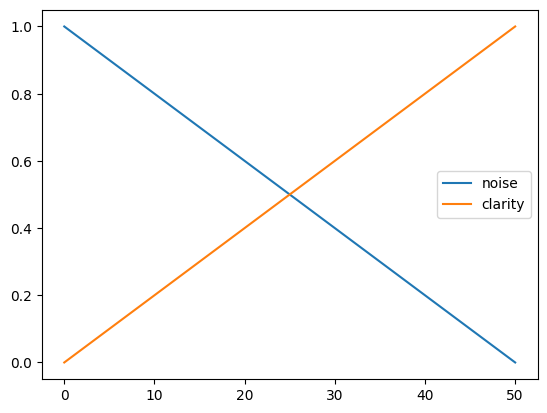

In [3]:
plt.plot(timebar,label='noise')
plt.plot(1-timebar,label='clarity')
plt.legend()

In [4]:
transform=transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
    ]
)

train_set=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 68990445.73it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
print(train_set)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )


In [6]:
# we wont train on full data lets make a subset of only a particular class
# Define the class you want to create a subset for
target_class = 5  # For example, let's say you want class 5  i love dogs

# Create a subset consisting of samples belonging to the target class
subset_indices = [i for i, (_, label) in enumerate(train_set) if label == target_class]
subset = torch.utils.data.Subset(train_set, subset_indices)

In [7]:
trainloader=torch.utils.data.DataLoader(subset,batch_size=batch_size,shuffle=True,num_workers=2)

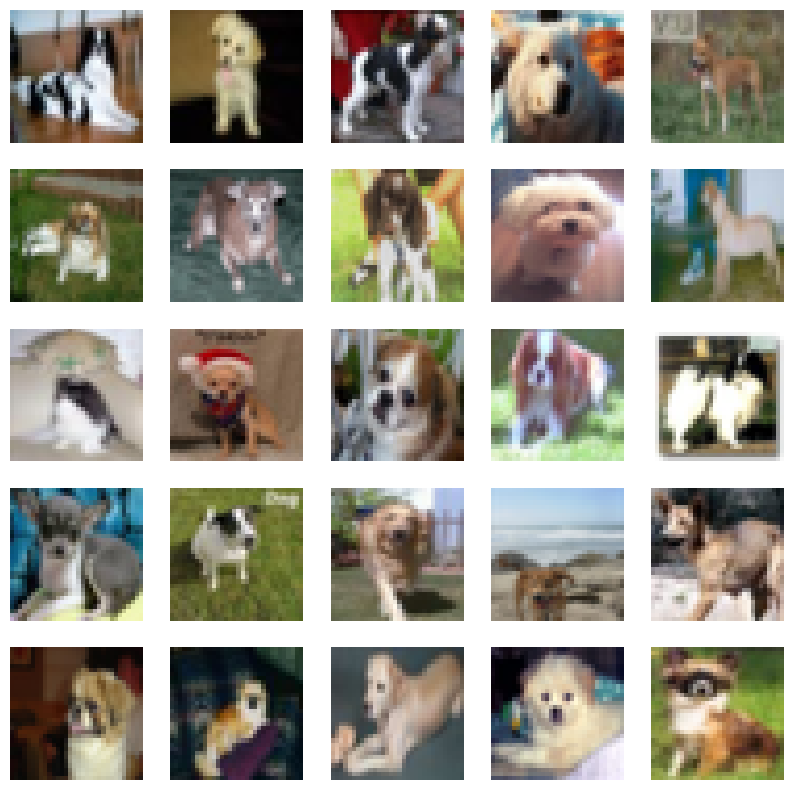

In [8]:
def cvtImg(img):
    img = img.permute([0, 2, 3, 1])
    img = img - img.min()
    img = (img / img.max())
    return img.numpy().astype(np.float32)

def show_examples(x):
    plt.figure(figsize=(10, 10))
    imgs = cvtImg(x)
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')

x, _ = next(iter(trainloader))
show_examples(x)


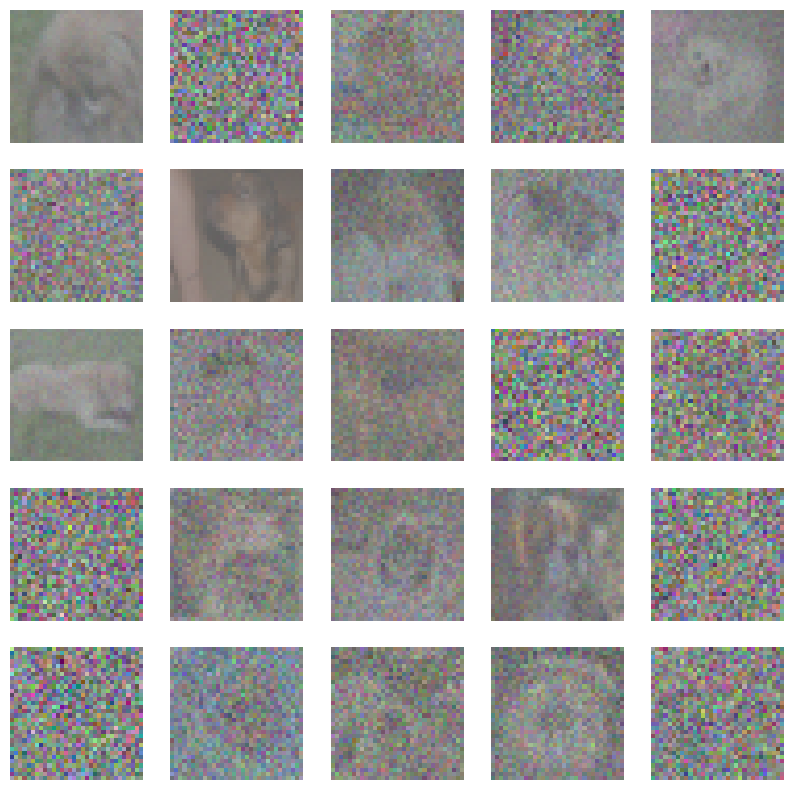

In [9]:
def forward_diff(image,timestep):
  a=timebar[timestep]
  b=timebar[timestep+1]#timebar with a given time value represents a level of noise corresponding to the timestep given,look at the graph,b is less noisy
  noise=np.random.normal(size=image.shape)#noise to be added
  a=a.reshape((-1,1,1,1))
  b=b.reshape((-1,1,1,1))
  image_a=image*(1-a)+noise*a#added scaled noise, like we did in scheduler algos
  image_b=image*(1-b)+noise*b
  return image_a ,image_b

def generate_timestep(kitne):#time steps pick bhi to krne pdenge for the algo,actually we are picking timestep to get their corresponding noisy images
  return np.random.randint(0,timesteps,size=kitne)

t=generate_timestep(25)
x,_=next(iter(trainloader))
a,b=forward_diff(x[:25],t)
show_examples(a)

In [10]:
#now we need a network to predict the noises in the image, with the help of image and corresponding timestep given as input
# we can use vae or unet,lets make a unet
class Block(nn.Module):
    def __init__(self, in_channels=128, size=32):
        super(Block, self).__init__()

        self.conv_param = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)
        self.conv_out = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)

        self.dense_ts = nn.Linear(192, 128)

        self.layer_norm = nn.LayerNorm([128, size, size])

    def forward(self, x_img, x_ts):
        x_parameter = f.relu(self.conv_param(x_img))#op=128c

        time_parameter = f.relu(self.dense_ts(x_ts))
        time_parameter = time_parameter.view(-1, 128, 1, 1)#op=128c
        x_parameter = x_parameter * time_parameter

        x_out = self.conv_out(x_img)
        x_out = x_out + x_parameter
        x_out = f.relu(self.layer_norm(x_out))

        return x_out

In [11]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.l_ts = nn.Sequential(
            nn.Linear(1, 192),
            nn.LayerNorm([192]),
            nn.ReLU(),
        )

        self.down_x32 = Block(in_channels=3, size=32)
        self.down_x16 = Block(size=16)
        self.down_x8 = Block(size=8)
        self.down_x4 = Block(size=4)

        self.mlp = nn.Sequential(
            nn.Linear(2240, 128),
            nn.LayerNorm([128]),
            nn.ReLU(),

            nn.Linear(128, 32 * 4 * 4), # make [-1, 32, 4, 4]
            nn.LayerNorm([32 * 4 * 4]),
            nn.ReLU(),
        )

        self.up_x4 = Block(in_channels=32 + 128, size=4)
        self.up_x8 = Block(in_channels=256, size=8)
        self.up_x16 = Block(in_channels=256, size=16)
        self.up_x32 = Block(in_channels=256, size=32)

        self.cnn_output = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=1, padding=0)

        # make optimizer
        self.opt = torch.optim.Adam(self.parameters(), lr=0.0008)

    def forward(self, x, x_ts):
        x_ts = self.l_ts(x_ts)

        # ----- left ( down ) -----
        blocks = [
            self.down_x32,
            self.down_x16,
            self.down_x8,
            self.down_x4,
        ]
        x_left_layers = []
        for i, block in enumerate(blocks):
            x = block(x, x_ts)
            x_left_layers.append(x)
            if i < len(blocks) - 1:
                x = f.max_pool2d(x, 2)

        # ----- MLP -----
        x = x.view(-1, 128 * 4 * 4)
        x = torch.cat([x, x_ts], dim=1)
        x = self.mlp(x)
        x = x.view(-1, 32, 4, 4)

        # ----- right ( up ) -----
        blocks = [
            self.up_x4,
            self.up_x8,
            self.up_x16,
            self.up_x32,
        ]

        for i, block in enumerate(blocks):
            # cat left
            x_left = x_left_layers[len(blocks) - i - 1]
            x = torch.cat([x, x_left], dim=1)

            x = block(x, x_ts)
            if i < len(blocks) - 1:
                x = f.interpolate(x, scale_factor=2, mode='bilinear')

        # ----- output -----
        x = self.cnn_output(x)

        return x

model = Model().to(device)

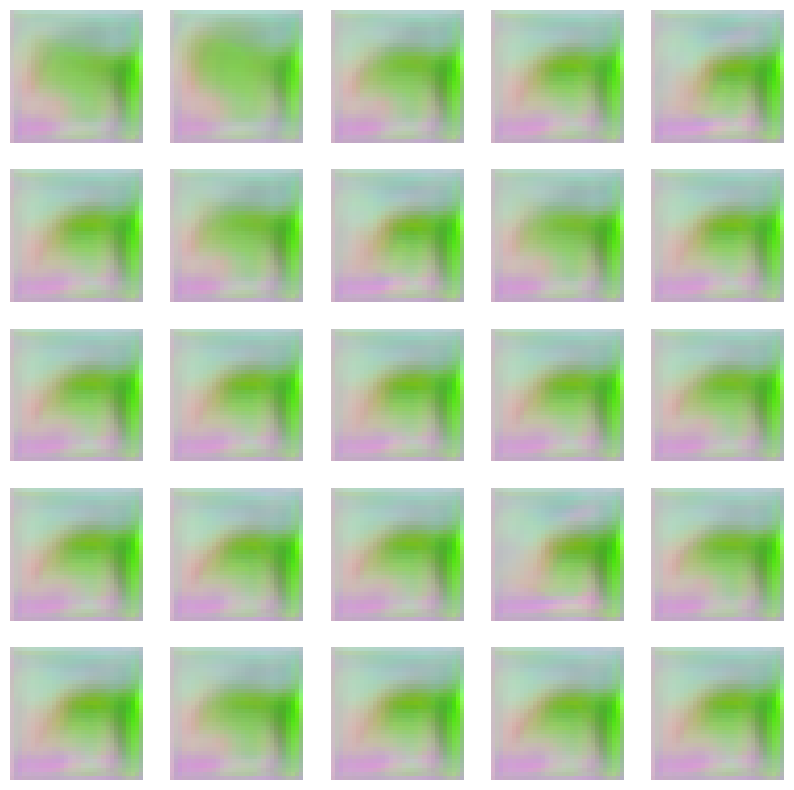

In [12]:
def predict(x_idx=None):
    x = torch.randn(32, 3, img_sz, img_sz).to(device)
    with torch.no_grad():
        for i in range(timesteps):
            t = i
            x = model(x, torch.full([32, 1], t, dtype=torch.float, device=device))

    show_examples(x.cpu())

predict()

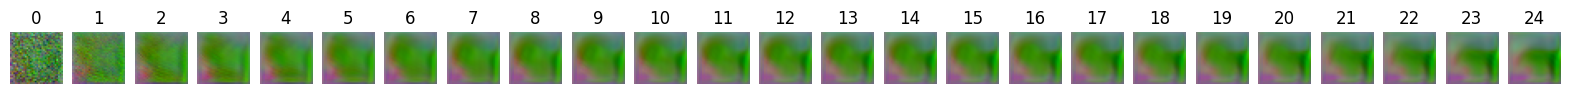

In [13]:
def predict_step():
    xs = []
    x = torch.randn(size=(8, 3, img_sz, img_sz), device=device)

    with torch.no_grad():
        for i in range(timesteps):
            t = i
            x = model(x, torch.full([8, 1], t, dtype=torch.float, device=device))
            if i % 2 == 0:
                xs.append(x[0].cpu())
    xs = torch.stack(xs, dim=0)
    xs = torch.clip(xs, -1, 1)
    xs = cvtImg(xs)

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(xs[i])
        plt.title(f'{i}')
        plt.axis('off')

predict_step()

In [14]:
def train_one(x_img):
    x_ts = generate_timestep(len(x_img))
    x_a, x_b = forward_diff(x_img, x_ts)

    x_ts = torch.from_numpy(x_ts).view(-1, 1).float().to(device)
    x_a = x_a.float().to(device)
    x_b = x_b.float().to(device)

    y_p = model(x_a, x_ts)
    loss = torch.mean(torch.abs(y_p - x_b))
    model.opt.zero_grad()
    loss.backward()
    model.opt.step()

    return loss.item()

In [15]:
from tqdm.auto import tqdm

def train(R=50):
    for _ in tqdm(range(R), desc='Epoch'):
        total = len(trainloader)
        for j, (x_img, _) in enumerate(trainloader):
            loss = train_one(x_img)
            pg = (j / total) * 100
            if j % 5 == 0:
                tqdm.write(f'loss: {loss:.5f}, p: {pg:.2f}%')

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss: 0.53984, p: 0.00%
loss: 0.38776, p: 6.33%
loss: 0.31491, p: 12.66%
loss: 0.29651, p: 18.99%
loss: 0.23030, p: 25.32%
loss: 0.18135, p: 31.65%
loss: 0.16604, p: 37.97%
loss: 0.13900, p: 44.30%
loss: 0.11970, p: 50.63%
loss: 0.11185, p: 56.96%
loss: 0.08531, p: 63.29%
loss: 0.08919, p: 69.62%
loss: 0.08018, p: 75.95%
loss: 0.07542, p: 82.28%
loss: 0.06831, p: 88.61%
loss: 0.07133, p: 94.94%
loss: 0.07618, p: 0.00%
loss: 0.06533, p: 6.33%
loss: 0.05792, p: 12.66%
loss: 0.05112, p: 18.99%
loss: 0.04865, p: 25.32%
loss: 0.05029, p: 31.65%
loss: 0.04934, p: 37.97%
loss: 0.05322, p: 44.30%
loss: 0.04823, p: 50.63%
loss: 0.05566, p: 56.96%
loss: 0.04315, p: 63.29%
loss: 0.04653, p: 69.62%
loss: 0.03670, p: 75.95%
loss: 0.03670, p: 82.28%
loss: 0.03725, p: 88.61%
loss: 0.03651, p: 94.94%
loss: 0.03628, p: 0.00%
loss: 0.03401, p: 6.33%
loss: 0.03136, p: 12.66%
loss: 0.03331, p: 18.99%
loss: 0.03268, p: 25.32%
loss: 0.03438, p: 31.65%
loss: 0.03354, p: 37.97%
loss: 0.02992, p: 44.30%
loss: 

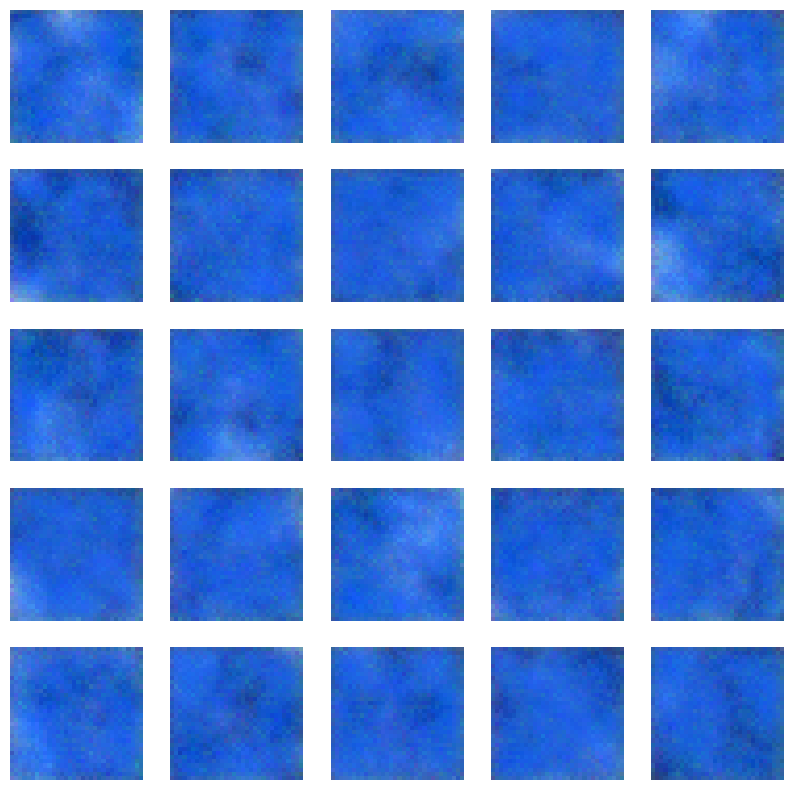

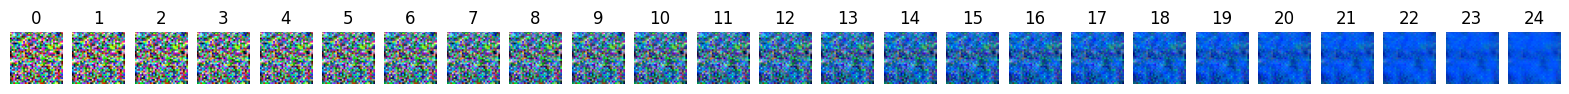

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss: 0.01432, p: 0.00%
loss: 0.01183, p: 6.33%
loss: 0.01036, p: 12.66%
loss: 0.01082, p: 18.99%
loss: 0.00997, p: 25.32%
loss: 0.01025, p: 31.65%
loss: 0.00970, p: 37.97%
loss: 0.01129, p: 44.30%
loss: 0.01149, p: 50.63%
loss: 0.00914, p: 56.96%
loss: 0.01057, p: 63.29%
loss: 0.01119, p: 69.62%
loss: 0.01025, p: 75.95%
loss: 0.00937, p: 82.28%
loss: 0.00985, p: 88.61%
loss: 0.01028, p: 94.94%
loss: 0.01066, p: 0.00%
loss: 0.01188, p: 6.33%
loss: 0.01158, p: 12.66%
loss: 0.00997, p: 18.99%
loss: 0.00960, p: 25.32%
loss: 0.01154, p: 31.65%
loss: 0.01081, p: 37.97%
loss: 0.01021, p: 44.30%
loss: 0.01400, p: 50.63%
loss: 0.01105, p: 56.96%
loss: 0.01057, p: 63.29%
loss: 0.01141, p: 69.62%
loss: 0.01041, p: 75.95%
loss: 0.01002, p: 82.28%
loss: 0.01173, p: 88.61%
loss: 0.01045, p: 94.94%
loss: 0.01069, p: 0.00%
loss: 0.01093, p: 6.33%
loss: 0.01189, p: 12.66%
loss: 0.00985, p: 18.99%
loss: 0.00985, p: 25.32%
loss: 0.00981, p: 31.65%
loss: 0.01130, p: 37.97%
loss: 0.01066, p: 44.30%
loss: 

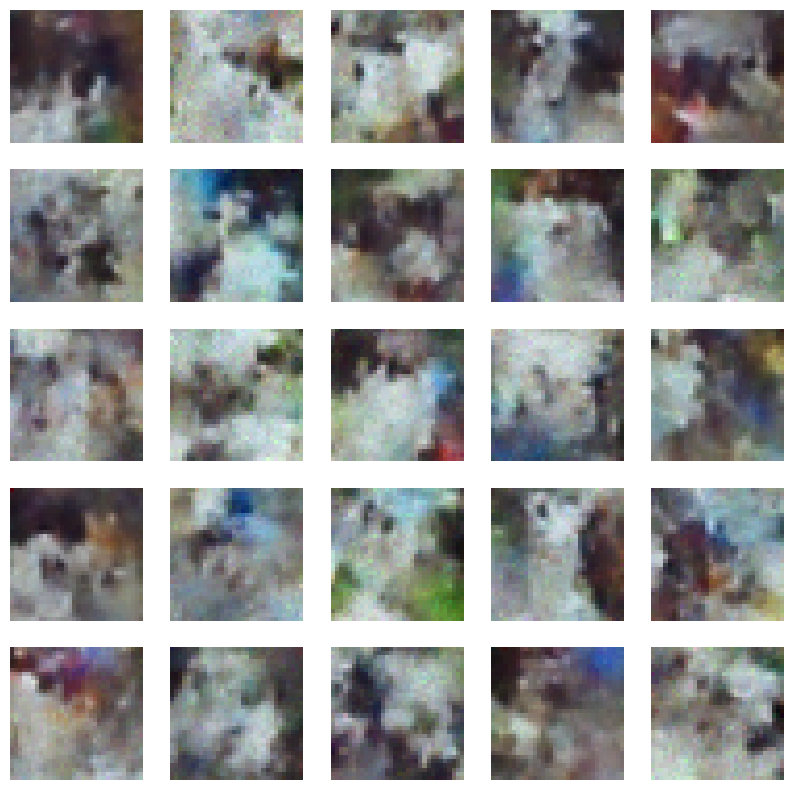

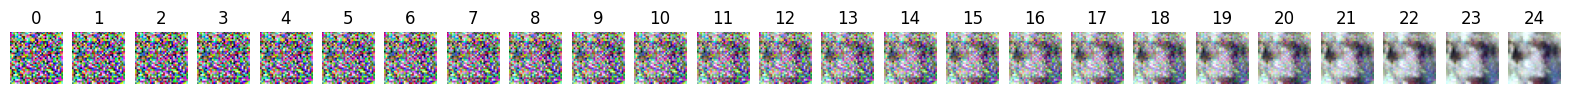

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss: 0.00842, p: 0.00%
loss: 0.00919, p: 6.33%
loss: 0.00971, p: 12.66%
loss: 0.00872, p: 18.99%
loss: 0.00920, p: 25.32%
loss: 0.00847, p: 31.65%
loss: 0.00969, p: 37.97%
loss: 0.00850, p: 44.30%
loss: 0.00945, p: 50.63%
loss: 0.00915, p: 56.96%
loss: 0.00852, p: 63.29%
loss: 0.00829, p: 69.62%
loss: 0.00865, p: 75.95%
loss: 0.00909, p: 82.28%
loss: 0.00763, p: 88.61%
loss: 0.00988, p: 94.94%
loss: 0.01161, p: 0.00%
loss: 0.00817, p: 6.33%
loss: 0.00830, p: 12.66%
loss: 0.00791, p: 18.99%
loss: 0.00811, p: 25.32%
loss: 0.00792, p: 31.65%
loss: 0.00885, p: 37.97%
loss: 0.00843, p: 44.30%
loss: 0.00818, p: 50.63%
loss: 0.00791, p: 56.96%
loss: 0.00788, p: 63.29%
loss: 0.00906, p: 69.62%
loss: 0.00812, p: 75.95%
loss: 0.00930, p: 82.28%
loss: 0.00870, p: 88.61%
loss: 0.00793, p: 94.94%
loss: 0.00863, p: 0.00%
loss: 0.00835, p: 6.33%
loss: 0.00813, p: 12.66%
loss: 0.00781, p: 18.99%
loss: 0.00770, p: 25.32%
loss: 0.00876, p: 31.65%
loss: 0.00796, p: 37.97%
loss: 0.00858, p: 44.30%
loss: 

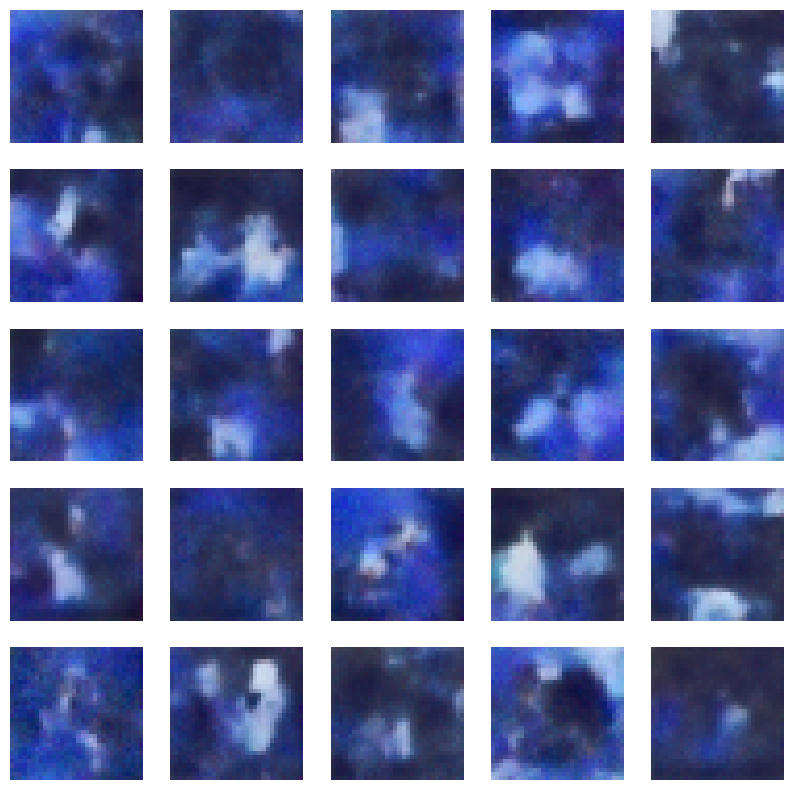

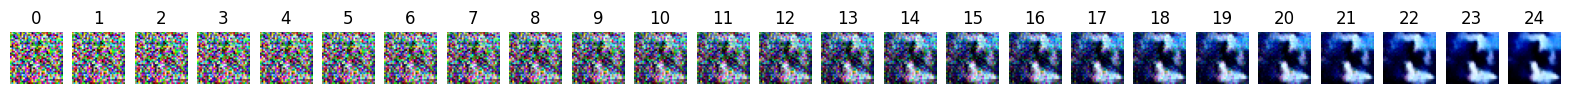

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss: 0.01002, p: 0.00%
loss: 0.00909, p: 6.33%
loss: 0.00748, p: 12.66%
loss: 0.00791, p: 18.99%
loss: 0.00818, p: 25.32%
loss: 0.00821, p: 31.65%
loss: 0.00743, p: 37.97%
loss: 0.00763, p: 44.30%
loss: 0.00787, p: 50.63%
loss: 0.00870, p: 56.96%
loss: 0.00733, p: 63.29%
loss: 0.00806, p: 69.62%
loss: 0.00751, p: 75.95%
loss: 0.00750, p: 82.28%
loss: 0.00842, p: 88.61%
loss: 0.00814, p: 94.94%
loss: 0.00734, p: 0.00%
loss: 0.00774, p: 6.33%
loss: 0.00761, p: 12.66%
loss: 0.00762, p: 18.99%
loss: 0.00775, p: 25.32%
loss: 0.00723, p: 31.65%
loss: 0.00782, p: 37.97%
loss: 0.00753, p: 44.30%
loss: 0.00835, p: 50.63%
loss: 0.00747, p: 56.96%
loss: 0.00742, p: 63.29%
loss: 0.00720, p: 69.62%
loss: 0.00752, p: 75.95%
loss: 0.00788, p: 82.28%
loss: 0.00807, p: 88.61%
loss: 0.00692, p: 94.94%
loss: 0.00752, p: 0.00%
loss: 0.00806, p: 6.33%
loss: 0.00769, p: 12.66%
loss: 0.00814, p: 18.99%
loss: 0.00802, p: 25.32%
loss: 0.00828, p: 31.65%
loss: 0.00784, p: 37.97%
loss: 0.00847, p: 44.30%
loss: 

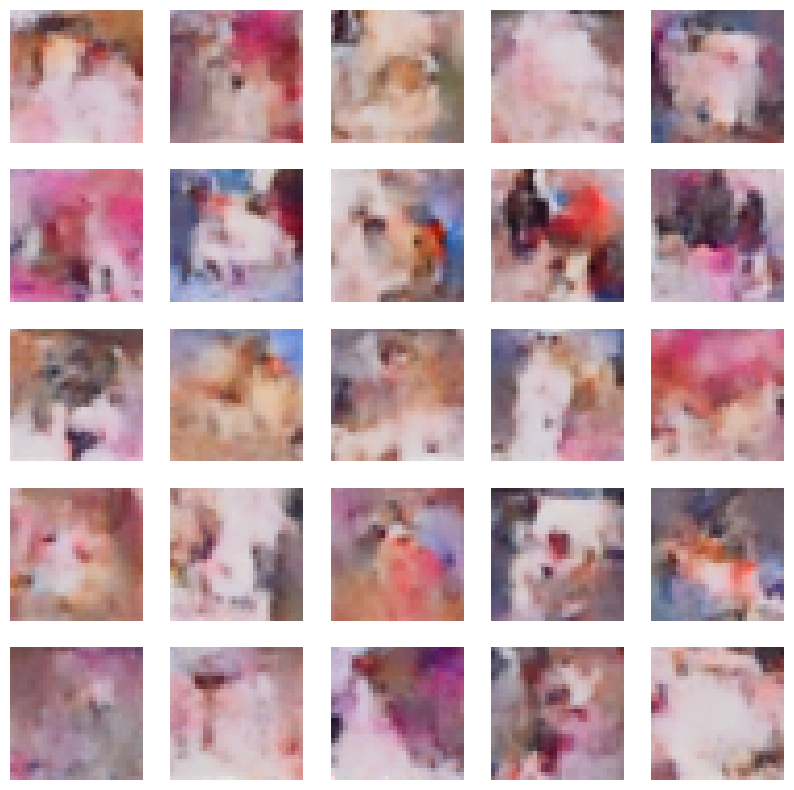

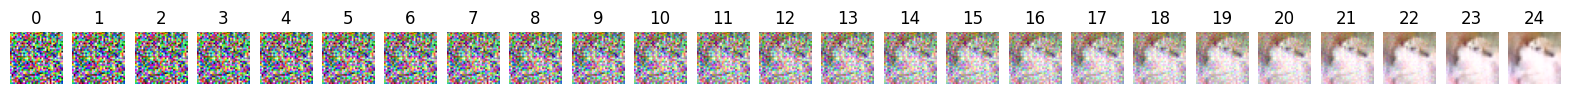

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss: 0.00776, p: 0.00%
loss: 0.00668, p: 6.33%
loss: 0.00744, p: 12.66%
loss: 0.00690, p: 18.99%
loss: 0.00718, p: 25.32%
loss: 0.00748, p: 31.65%
loss: 0.00766, p: 37.97%
loss: 0.00777, p: 44.30%
loss: 0.00751, p: 50.63%
loss: 0.00744, p: 56.96%
loss: 0.00740, p: 63.29%
loss: 0.00689, p: 69.62%
loss: 0.00736, p: 75.95%
loss: 0.00707, p: 82.28%
loss: 0.00694, p: 88.61%
loss: 0.00728, p: 94.94%
loss: 0.00735, p: 0.00%
loss: 0.00826, p: 6.33%
loss: 0.00732, p: 12.66%
loss: 0.00763, p: 18.99%
loss: 0.00771, p: 25.32%
loss: 0.00758, p: 31.65%
loss: 0.00722, p: 37.97%
loss: 0.00716, p: 44.30%
loss: 0.00742, p: 50.63%
loss: 0.00745, p: 56.96%
loss: 0.00728, p: 63.29%
loss: 0.00734, p: 69.62%
loss: 0.00729, p: 75.95%
loss: 0.00689, p: 82.28%
loss: 0.00704, p: 88.61%
loss: 0.00741, p: 94.94%
loss: 0.00787, p: 0.00%
loss: 0.00707, p: 6.33%
loss: 0.00729, p: 12.66%
loss: 0.00780, p: 18.99%
loss: 0.00738, p: 25.32%
loss: 0.00737, p: 31.65%
loss: 0.00788, p: 37.97%
loss: 0.00735, p: 44.30%
loss: 

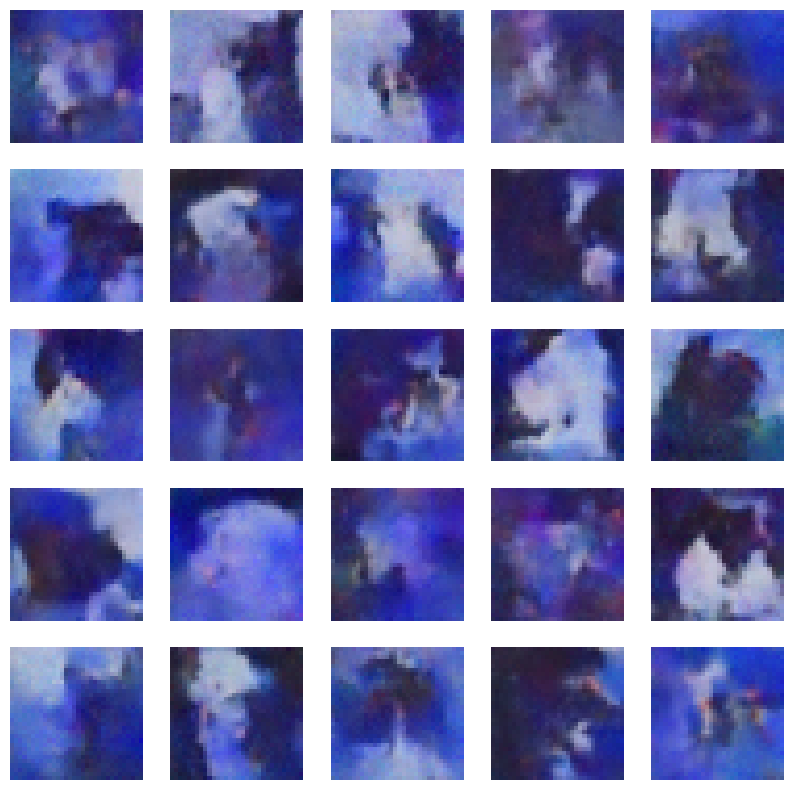

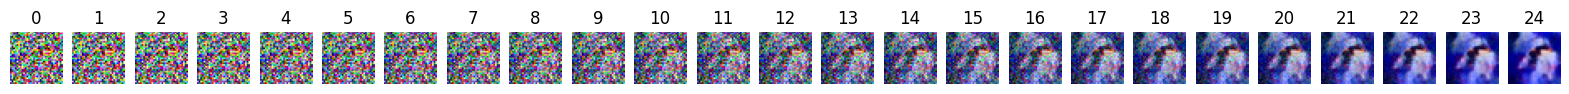

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss: 0.00783, p: 0.00%
loss: 0.00772, p: 6.33%
loss: 0.00704, p: 12.66%
loss: 0.00678, p: 18.99%
loss: 0.00706, p: 25.32%
loss: 0.00771, p: 31.65%
loss: 0.00697, p: 37.97%
loss: 0.00713, p: 44.30%
loss: 0.00714, p: 50.63%
loss: 0.00728, p: 56.96%
loss: 0.00717, p: 63.29%
loss: 0.00669, p: 69.62%
loss: 0.00676, p: 75.95%
loss: 0.00703, p: 82.28%
loss: 0.00724, p: 88.61%
loss: 0.00723, p: 94.94%
loss: 0.00708, p: 0.00%
loss: 0.00713, p: 6.33%
loss: 0.00704, p: 12.66%
loss: 0.00785, p: 18.99%
loss: 0.00876, p: 25.32%
loss: 0.00705, p: 31.65%
loss: 0.00702, p: 37.97%
loss: 0.00701, p: 44.30%
loss: 0.00773, p: 50.63%
loss: 0.00724, p: 56.96%
loss: 0.00785, p: 63.29%
loss: 0.00720, p: 69.62%
loss: 0.00730, p: 75.95%
loss: 0.00740, p: 82.28%
loss: 0.00758, p: 88.61%
loss: 0.00754, p: 94.94%
loss: 0.00677, p: 0.00%
loss: 0.00755, p: 6.33%
loss: 0.00683, p: 12.66%
loss: 0.00715, p: 18.99%
loss: 0.00719, p: 25.32%
loss: 0.00772, p: 31.65%
loss: 0.00773, p: 37.97%
loss: 0.00699, p: 44.30%
loss: 

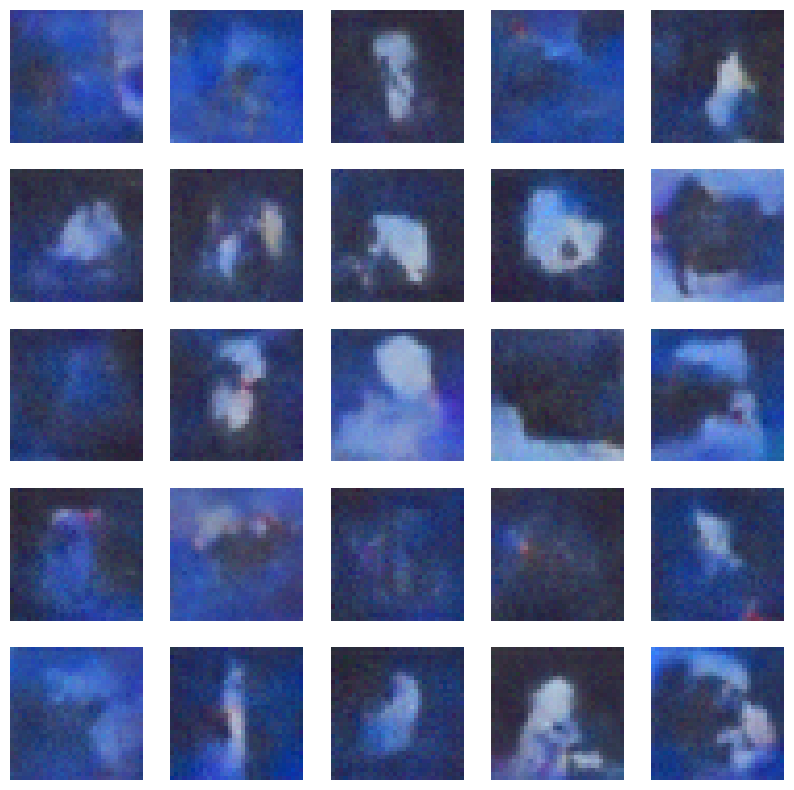

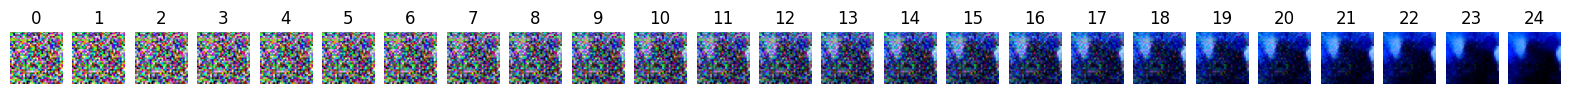

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss: 0.00803, p: 0.00%
loss: 0.00697, p: 6.33%
loss: 0.00762, p: 12.66%
loss: 0.00743, p: 18.99%
loss: 0.00742, p: 25.32%
loss: 0.00712, p: 31.65%
loss: 0.00783, p: 37.97%
loss: 0.00728, p: 44.30%
loss: 0.00686, p: 50.63%
loss: 0.00710, p: 56.96%
loss: 0.00758, p: 63.29%
loss: 0.00686, p: 69.62%
loss: 0.00699, p: 75.95%
loss: 0.00705, p: 82.28%
loss: 0.00680, p: 88.61%
loss: 0.00718, p: 94.94%
loss: 0.00672, p: 0.00%
loss: 0.00692, p: 6.33%
loss: 0.00703, p: 12.66%
loss: 0.00710, p: 18.99%
loss: 0.00721, p: 25.32%
loss: 0.00742, p: 31.65%
loss: 0.00726, p: 37.97%
loss: 0.00708, p: 44.30%
loss: 0.00691, p: 50.63%
loss: 0.00700, p: 56.96%
loss: 0.00667, p: 63.29%
loss: 0.00719, p: 69.62%
loss: 0.00661, p: 75.95%
loss: 0.00785, p: 82.28%
loss: 0.00750, p: 88.61%
loss: 0.00647, p: 94.94%
loss: 0.00778, p: 0.00%
loss: 0.00701, p: 6.33%
loss: 0.00732, p: 12.66%
loss: 0.00654, p: 18.99%
loss: 0.00701, p: 25.32%
loss: 0.00736, p: 31.65%
loss: 0.00725, p: 37.97%
loss: 0.00748, p: 44.30%
loss: 

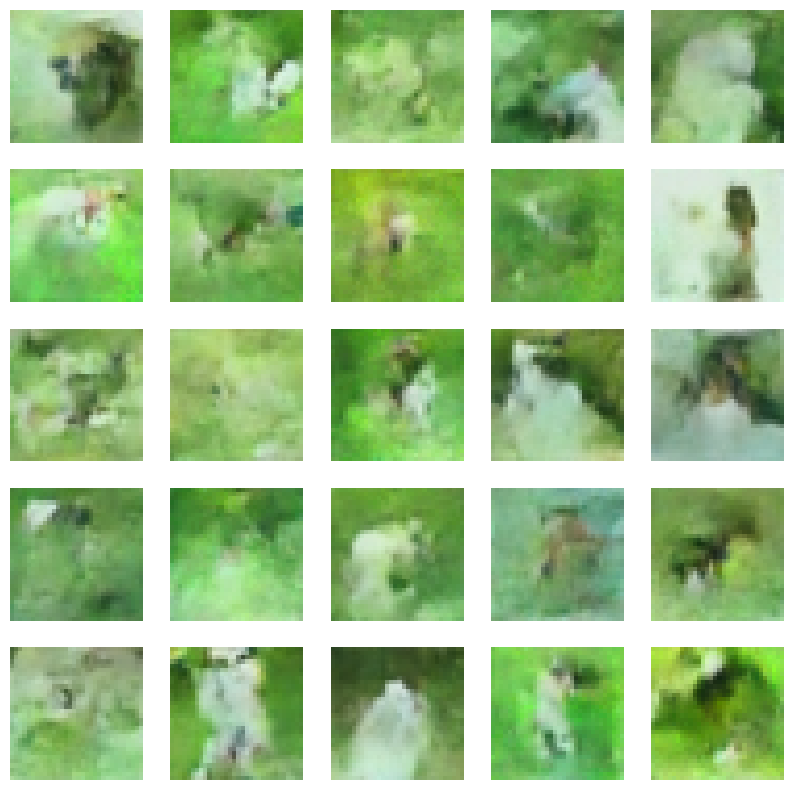

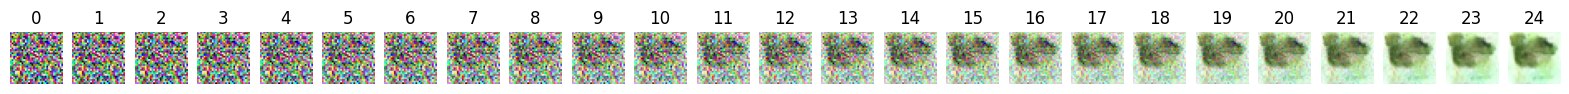

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss: 0.00760, p: 0.00%
loss: 0.00704, p: 6.33%
loss: 0.00738, p: 12.66%
loss: 0.00669, p: 18.99%
loss: 0.00690, p: 25.32%
loss: 0.00707, p: 31.65%
loss: 0.00680, p: 37.97%
loss: 0.00722, p: 44.30%
loss: 0.00673, p: 50.63%
loss: 0.00746, p: 56.96%
loss: 0.00723, p: 63.29%
loss: 0.00686, p: 69.62%
loss: 0.00688, p: 75.95%
loss: 0.00695, p: 82.28%
loss: 0.00725, p: 88.61%
loss: 0.00711, p: 94.94%
loss: 0.00766, p: 0.00%
loss: 0.00784, p: 6.33%
loss: 0.00765, p: 12.66%
loss: 0.00732, p: 18.99%
loss: 0.00663, p: 25.32%
loss: 0.00689, p: 31.65%
loss: 0.00688, p: 37.97%
loss: 0.00715, p: 44.30%
loss: 0.00710, p: 50.63%
loss: 0.00702, p: 56.96%
loss: 0.00696, p: 63.29%
loss: 0.00718, p: 69.62%
loss: 0.00680, p: 75.95%
loss: 0.00727, p: 82.28%
loss: 0.00723, p: 88.61%
loss: 0.00676, p: 94.94%
loss: 0.00689, p: 0.00%
loss: 0.00752, p: 6.33%
loss: 0.00748, p: 12.66%
loss: 0.00694, p: 18.99%
loss: 0.00695, p: 25.32%
loss: 0.00763, p: 31.65%
loss: 0.00700, p: 37.97%
loss: 0.00731, p: 44.30%
loss: 

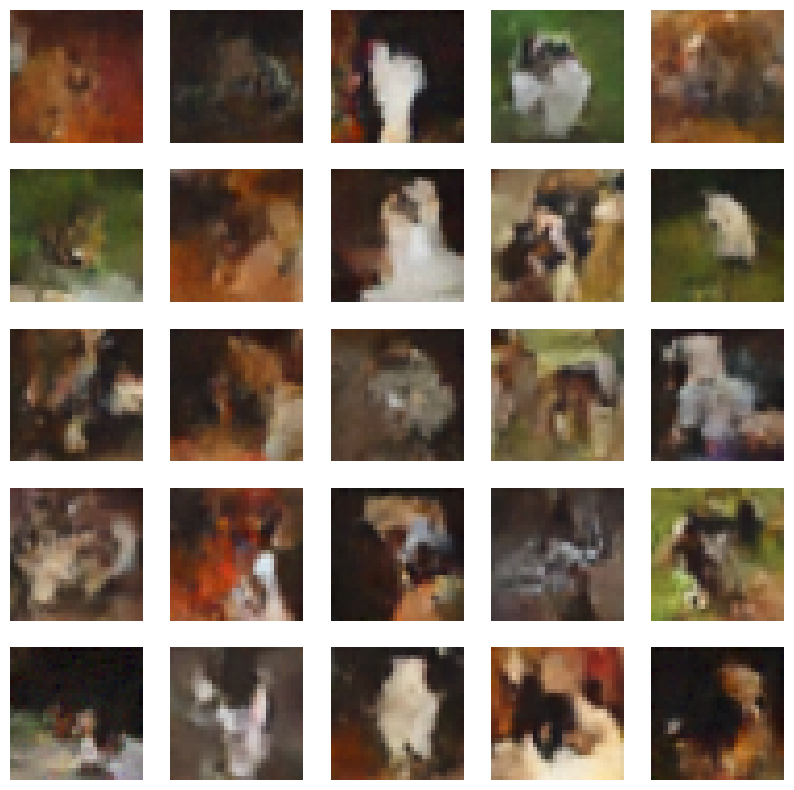

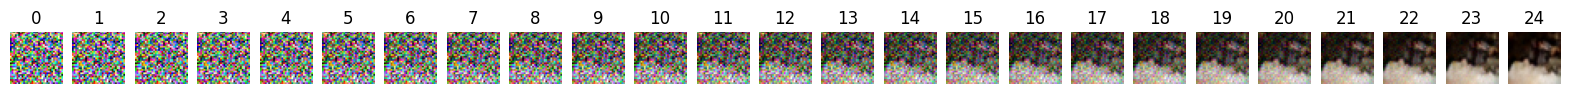

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss: 0.00754, p: 0.00%
loss: 0.00655, p: 6.33%
loss: 0.00679, p: 12.66%
loss: 0.00729, p: 18.99%
loss: 0.00698, p: 25.32%
loss: 0.00695, p: 31.65%
loss: 0.00671, p: 37.97%
loss: 0.00698, p: 44.30%
loss: 0.00730, p: 50.63%
loss: 0.00732, p: 56.96%
loss: 0.00752, p: 63.29%
loss: 0.00741, p: 69.62%
loss: 0.00694, p: 75.95%
loss: 0.00710, p: 82.28%
loss: 0.00684, p: 88.61%
loss: 0.00673, p: 94.94%
loss: 0.00720, p: 0.00%
loss: 0.00673, p: 6.33%
loss: 0.00685, p: 12.66%
loss: 0.00704, p: 18.99%
loss: 0.00710, p: 25.32%
loss: 0.00698, p: 31.65%
loss: 0.00692, p: 37.97%
loss: 0.00719, p: 44.30%
loss: 0.00694, p: 50.63%
loss: 0.00659, p: 56.96%
loss: 0.00715, p: 63.29%
loss: 0.00683, p: 69.62%
loss: 0.00673, p: 75.95%
loss: 0.00693, p: 82.28%
loss: 0.00655, p: 88.61%
loss: 0.00687, p: 94.94%
loss: 0.00671, p: 0.00%
loss: 0.00769, p: 6.33%
loss: 0.00701, p: 12.66%
loss: 0.00732, p: 18.99%
loss: 0.00768, p: 25.32%
loss: 0.00731, p: 31.65%
loss: 0.00685, p: 37.97%
loss: 0.00691, p: 44.30%
loss: 

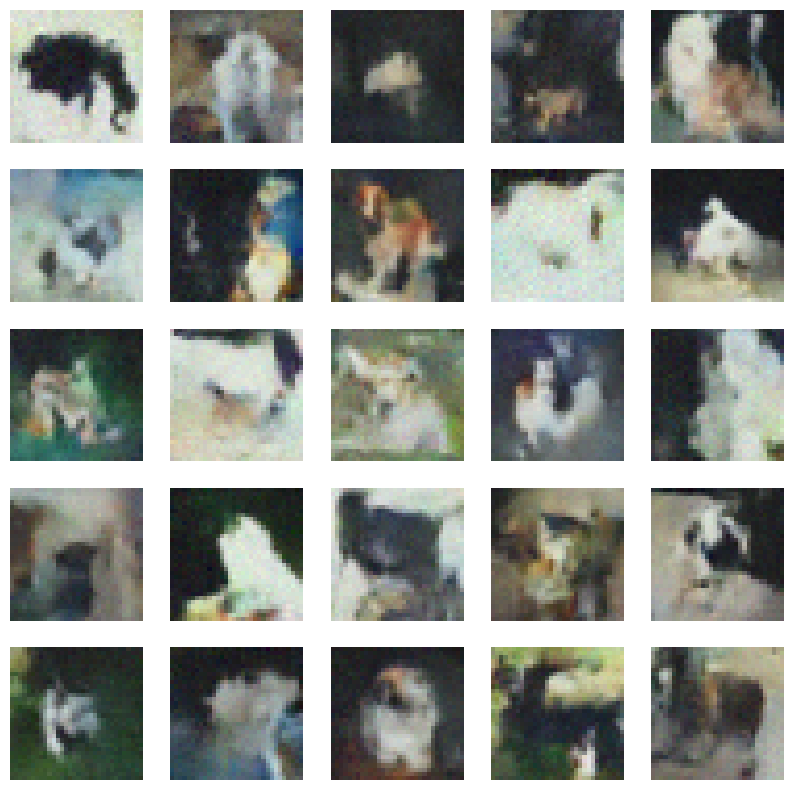

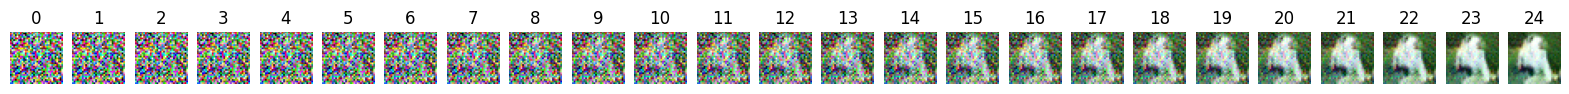

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss: 0.00696, p: 0.00%
loss: 0.00652, p: 6.33%
loss: 0.00692, p: 12.66%
loss: 0.00694, p: 18.99%
loss: 0.00687, p: 25.32%
loss: 0.00675, p: 31.65%
loss: 0.00769, p: 37.97%
loss: 0.00801, p: 44.30%
loss: 0.00780, p: 50.63%
loss: 0.00721, p: 56.96%
loss: 0.00710, p: 63.29%
loss: 0.00734, p: 69.62%
loss: 0.00720, p: 75.95%
loss: 0.00688, p: 82.28%
loss: 0.00698, p: 88.61%
loss: 0.00733, p: 94.94%
loss: 0.00677, p: 0.00%
loss: 0.00729, p: 6.33%
loss: 0.00686, p: 12.66%
loss: 0.00648, p: 18.99%
loss: 0.00676, p: 25.32%
loss: 0.00663, p: 31.65%
loss: 0.00699, p: 37.97%
loss: 0.00702, p: 44.30%
loss: 0.00696, p: 50.63%
loss: 0.00741, p: 56.96%
loss: 0.00660, p: 63.29%
loss: 0.00636, p: 69.62%
loss: 0.00694, p: 75.95%
loss: 0.00704, p: 82.28%
loss: 0.00688, p: 88.61%
loss: 0.00668, p: 94.94%
loss: 0.00747, p: 0.00%
loss: 0.00655, p: 6.33%
loss: 0.00642, p: 12.66%
loss: 0.00698, p: 18.99%
loss: 0.00717, p: 25.32%
loss: 0.00712, p: 31.65%
loss: 0.00646, p: 37.97%
loss: 0.00648, p: 44.30%
loss: 

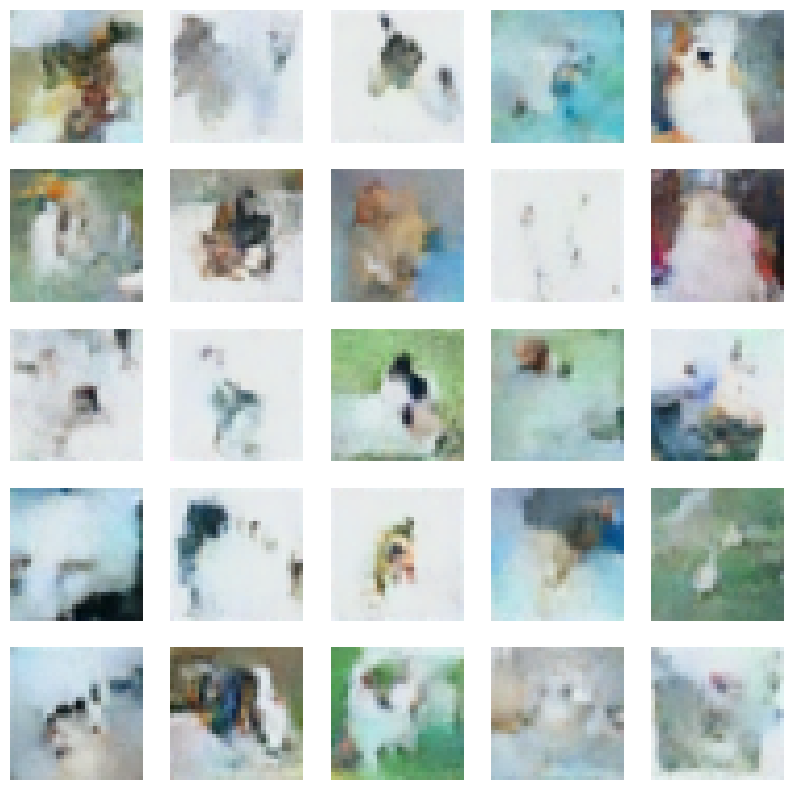

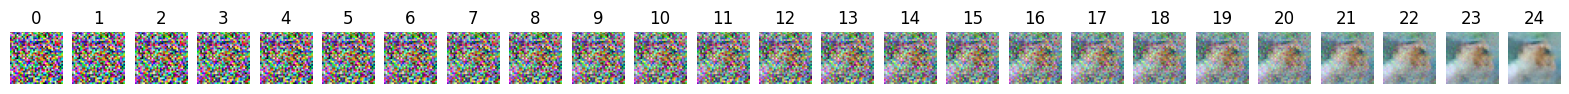

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss: 0.00736, p: 0.00%
loss: 0.00701, p: 6.33%
loss: 0.00676, p: 12.66%
loss: 0.00723, p: 18.99%
loss: 0.00680, p: 25.32%
loss: 0.00668, p: 31.65%
loss: 0.00711, p: 37.97%
loss: 0.00686, p: 44.30%
loss: 0.00709, p: 50.63%
loss: 0.00634, p: 56.96%
loss: 0.00676, p: 63.29%
loss: 0.00676, p: 69.62%
loss: 0.00679, p: 75.95%
loss: 0.00660, p: 82.28%
loss: 0.00692, p: 88.61%
loss: 0.00729, p: 94.94%
loss: 0.00728, p: 0.00%
loss: 0.00659, p: 6.33%
loss: 0.00651, p: 12.66%
loss: 0.00719, p: 18.99%
loss: 0.00717, p: 25.32%
loss: 0.00696, p: 31.65%
loss: 0.00678, p: 37.97%
loss: 0.00715, p: 44.30%
loss: 0.00661, p: 50.63%
loss: 0.00736, p: 56.96%
loss: 0.00722, p: 63.29%
loss: 0.00696, p: 69.62%
loss: 0.00662, p: 75.95%
loss: 0.00655, p: 82.28%
loss: 0.00670, p: 88.61%
loss: 0.00655, p: 94.94%
loss: 0.00720, p: 0.00%
loss: 0.00701, p: 6.33%
loss: 0.00681, p: 12.66%
loss: 0.00678, p: 18.99%
loss: 0.00670, p: 25.32%
loss: 0.00648, p: 31.65%
loss: 0.00692, p: 37.97%
loss: 0.00687, p: 44.30%
loss: 

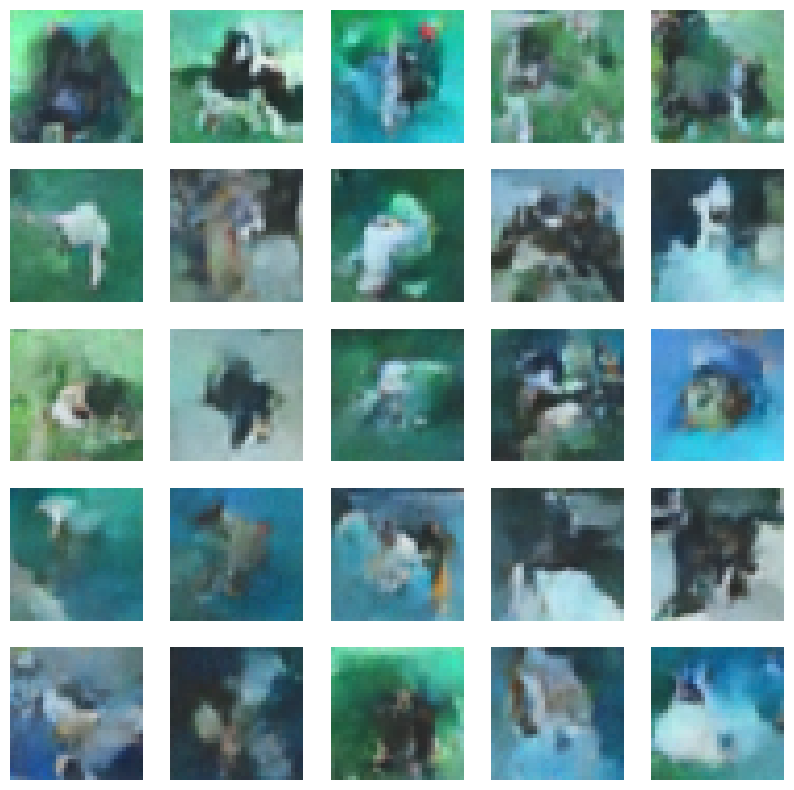

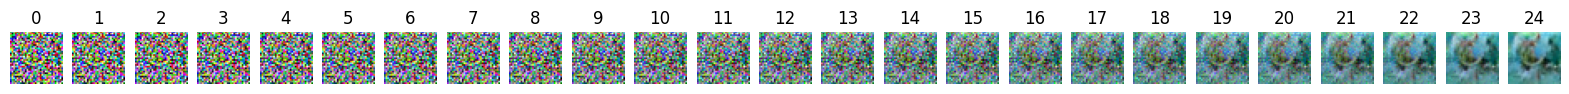

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss: 0.00701, p: 0.00%
loss: 0.00702, p: 6.33%
loss: 0.00694, p: 12.66%
loss: 0.00683, p: 18.99%
loss: 0.00693, p: 25.32%
loss: 0.00673, p: 31.65%
loss: 0.00712, p: 37.97%
loss: 0.00700, p: 44.30%
loss: 0.00652, p: 50.63%
loss: 0.00637, p: 56.96%
loss: 0.00670, p: 63.29%
loss: 0.00683, p: 69.62%
loss: 0.00651, p: 75.95%
loss: 0.00680, p: 82.28%
loss: 0.00653, p: 88.61%
loss: 0.00720, p: 94.94%
loss: 0.00734, p: 0.00%
loss: 0.00710, p: 6.33%
loss: 0.00662, p: 12.66%
loss: 0.00688, p: 18.99%
loss: 0.00699, p: 25.32%
loss: 0.00697, p: 31.65%
loss: 0.00676, p: 37.97%
loss: 0.00627, p: 44.30%
loss: 0.00699, p: 50.63%
loss: 0.00724, p: 56.96%
loss: 0.00691, p: 63.29%
loss: 0.00681, p: 69.62%
loss: 0.00657, p: 75.95%
loss: 0.00715, p: 82.28%
loss: 0.00684, p: 88.61%
loss: 0.00705, p: 94.94%
loss: 0.00688, p: 0.00%
loss: 0.00687, p: 6.33%
loss: 0.00696, p: 12.66%
loss: 0.00676, p: 18.99%
loss: 0.00666, p: 25.32%
loss: 0.00682, p: 31.65%
loss: 0.00667, p: 37.97%
loss: 0.00653, p: 44.30%
loss: 

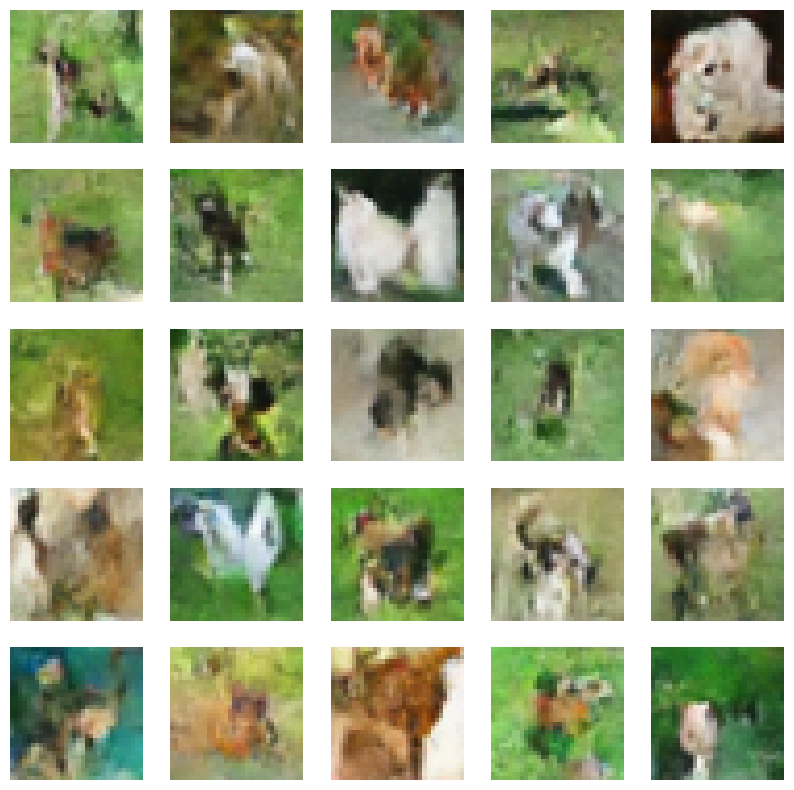

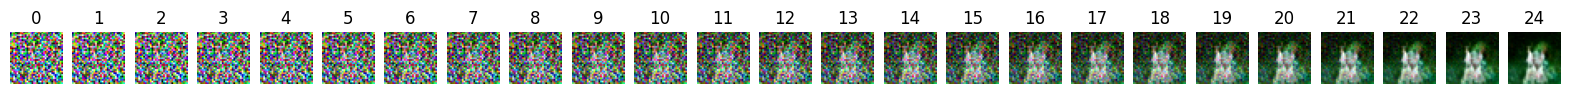

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

loss: 0.00625, p: 0.00%
loss: 0.00684, p: 6.33%
loss: 0.00642, p: 12.66%
loss: 0.00666, p: 18.99%
loss: 0.00701, p: 25.32%
loss: 0.00651, p: 31.65%
loss: 0.00687, p: 37.97%
loss: 0.00671, p: 44.30%
loss: 0.00636, p: 50.63%
loss: 0.00655, p: 56.96%
loss: 0.00662, p: 63.29%
loss: 0.00684, p: 69.62%
loss: 0.00717, p: 75.95%
loss: 0.00663, p: 82.28%
loss: 0.00702, p: 88.61%
loss: 0.00670, p: 94.94%
loss: 0.00661, p: 0.00%
loss: 0.00670, p: 6.33%
loss: 0.00688, p: 12.66%
loss: 0.00684, p: 18.99%
loss: 0.00677, p: 25.32%
loss: 0.00709, p: 31.65%
loss: 0.00675, p: 37.97%
loss: 0.00697, p: 44.30%
loss: 0.00675, p: 50.63%
loss: 0.00655, p: 56.96%
loss: 0.00669, p: 63.29%
loss: 0.00684, p: 69.62%
loss: 0.00708, p: 75.95%
loss: 0.00664, p: 82.28%
loss: 0.00681, p: 88.61%
loss: 0.00652, p: 94.94%
loss: 0.00706, p: 0.00%
loss: 0.00702, p: 6.33%
loss: 0.00727, p: 12.66%
loss: 0.00620, p: 18.99%
loss: 0.00615, p: 25.32%
loss: 0.00675, p: 31.65%
loss: 0.00655, p: 37.97%
loss: 0.00644, p: 44.30%
loss: 

In [ ]:
for _ in range(100):
    train()
    # reduce learning rate for next training
    for pg in model.opt.param_groups:
        pg['lr'] = max(0.000001, pg['lr'] * 0.9)

    # show result
    predict()
    predict_step()
    plt.show()